In [1]:
from fastai.vision import *

### Getting the data

In [3]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/accounts/ekarakoy/.fastai/data/planet')

In [5]:
!ls /accounts/ekarakoy/.kaggle/

kaggle.json


In [6]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}

 99%|███████████████████████████████████████▋| 596M/600M [00:24<00:00, 8.05MB/s]
100%|████████████████████████████████████████| 600M/600M [00:24<00:00, 25.9MB/s]
100%|█████████████████████████████████████████| 159k/159k [00:00<00:00, 759kB/s]



In [7]:
! unzip -q -n {path}/train_v2.csv.zip -d {path}

In [8]:
! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

## Multiclassification

Here, each picture can have multiple labels.  Inspecting the first few rows of the labels csv file yields:

In [4]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [5]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

Below, parentheses are added to use a multiline statement without need for '\'.

In [7]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .split_by_rand_pct(0.2).label_from_df(label_delim=' '))

In [11]:
data = (src.transform(tfms, size=128).databunch(bs=32).normalize(imagenet_stats))

In [62]:
data.train_ds

LabelList (32384 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: MultiCategoryList
haze;primary,clear;primary,clear;primary,haze;primary;water,agriculture;clear;cultivation;primary;water
Path: /accounts/ekarakoy/.fastai/data/planet

In [12]:
data.batch_size

32

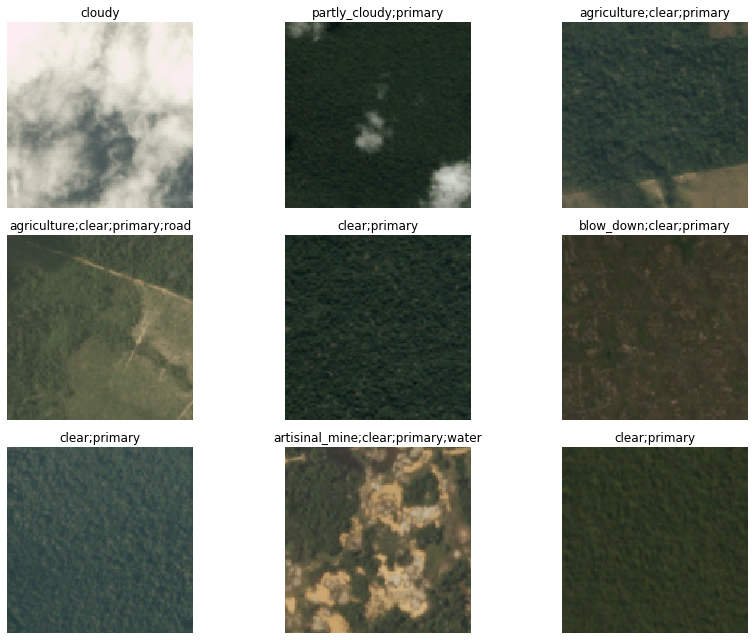

In [13]:
data.show_batch(rows=3, figsize=(12, 9))

To create a `Learner` we use the same function as in lesson 1. Our base architecture is resnet50 again, but the metrics are a little bit differeent: we use `accuracy_thresh` instead of `accuracy`. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. `accuracy_thresh` selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. See [here](https://en.wikipedia.org/wiki/F1_score) for more details.

In [14]:
arch = models.resnet50

In [15]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
lear = cnn_learner(data, arch, metrics=[acc_02, f_score])

In [16]:
lear.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


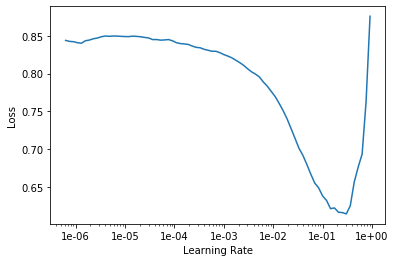

In [17]:
lear.recorder.plot()

First fit the head of the network

In [18]:
lr = 0.01

In [19]:
lear.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.129647,0.109773,0.949671,0.904337,01:57
1,0.110116,0.098599,0.946335,0.913522,01:58
2,0.107851,0.105226,0.955346,0.914892,01:58
3,0.099024,0.089501,0.955702,0.923491,01:58
4,0.097166,0.088463,0.957592,0.923587,01:58


In [32]:
lear.save('stage-1-rn50')

Next is to fine-tune the whole model.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


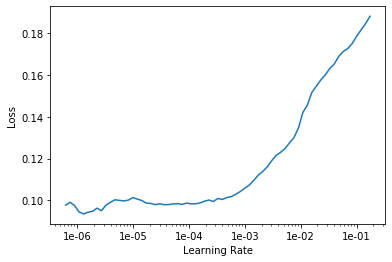

In [21]:
lear.unfreeze()
lear.lr_find()
lear.recorder.plot()

In [22]:
lear.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.098295,0.097915,0.956022,0.911237,02:43
1,0.101073,0.089687,0.955775,0.922516,02:43
2,0.098276,0.087407,0.957803,0.924920,02:43
3,0.084491,0.084732,0.959605,0.927872,02:43
4,0.086070,0.083577,0.958682,0.928106,02:43


In [23]:
lear.save('stage-2-rn50')

In [24]:
data = (src.transform(tfms, size=256)
       .databunch(bs=32).normalize(imagenet_stats))
lear.data = data

In [25]:
data.batch_size

32

In [26]:
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [27]:
lear.freeze()

In [ ]:
lear.lr_find()

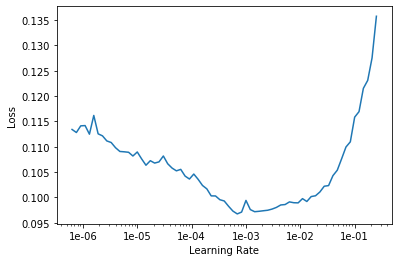

In [29]:
lear.recorder.plot()

In [30]:
lr=1e-2/2

In [31]:
lear.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.095309,0.085327,0.955986,0.926229,06:57
1,0.090325,0.086782,0.961422,0.926098,06:56
2,0.093444,0.090957,0.959321,0.927851,06:56
3,0.089069,0.082515,0.958224,0.929466,06:56
4,0.089336,0.082132,0.959816,0.930012,06:56


In [34]:
lear.save('stage-1-256-rn50')

In [35]:
lear.unfreeze()

In [36]:
lear.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.086689,0.085611,0.958951,0.928232,08:52
1,0.089687,0.088748,0.955870,0.927452,08:53
2,0.086435,0.085388,0.959118,0.928531,08:53
3,0.085948,0.081123,0.959845,0.930069,08:53
4,0.083289,0.087217,0.961574,0.929122,08:53


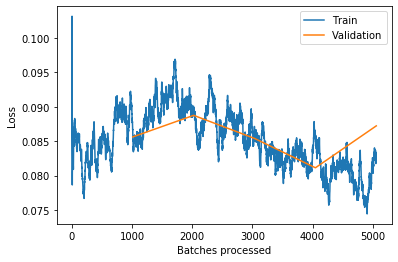

In [37]:
lear.recorder.plot_losses()

In [38]:
lear.save('stage-2-256-rn50')

## Submitting results

First, export the model to be used - this gives the model an 'export' state, making it THE model to load for testing

In [42]:
lear.export()

In [39]:
path

PosixPath('/accounts/ekarakoy/.fastai/data/planet')

In [40]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}

 99%|███████████████████████████████████████▋| 598M/603M [00:17<00:00, 51.6MB/s]
100%|████████████████████████████████████████| 603M/603M [00:18<00:00, 34.9MB/s]


In [41]:
! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}

In [43]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}

100%|███████████████████████████████████████▉| 303M/304M [00:08<00:00, 44.0MB/s]
100%|████████████████████████████████████████| 304M/304M [00:08<00:00, 39.3MB/s]


In [46]:
!7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

In [47]:
test = ImageList.from_folder(path/'test-jpg').add(ImageList.from_folder(path/'test-jpg-additional'))
len(test)

61191

In [48]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [49]:
thresh = 0.2
labelled_preds =[' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [50]:
labelled_preds[:5]

['partly_cloudy primary',
 'clear primary water',
 'agriculture clear primary road water',
 'agriculture clear cultivation haze primary',
 'agriculture clear habitation primary road']

In [51]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [52]:
df = pd.DataFrame({'image_name': fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [60]:
df.to_csv(path/'submission.csv', index=False)

In [57]:
from datetime import datetime as dt
submission_tag = f"Submission_{dt.now()}"

In [61]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m submission_tag

100%|██████████████████████████████████████| 2.15M/2.15M [00:01<00:00, 1.78MB/s]
Successfully submitted to Planet: Understanding the Amazon from Space